# Title: A Predictive Analysis of Loan Approvals through Classification Modeling and Cloud Computing

Saba Alemayehu, Dennis Myasnyankin, and Anusia Edward

In [106]:
#pip install PyAthena

In [107]:
#pip install -U seaborn

In [108]:
#pip install awswrangler

In [109]:
#pip install seaborn==0.11.0

# Import Library

In [59]:
import boto3
import sagemaker
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pyathena as pa
import awswrangler as wr 
from pyathena.pandas.cursor import PandasCursor

from sklearn.preprocessing import MultiLabelBinarizer

import warnings
warnings.filterwarnings("ignore")

# Import Data

# Dataset 1 trans.csv

In [60]:
# CSV data from s3 bucket
trans_1_df = wr.s3.read_csv(path="s3://s3://ads508patient/patient_folder/trans.csv")

In [61]:
trans_1_df.head()

,Unnamed: 0,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,0,1,1,1995-03-24,PRIJEM,VKLAD,1000,1000,NaN,NaN,NaN
1,1,5,1,1995-04-13,PRIJEM,PREVOD Z UCTU,3679,4679,NaN,AB,41403269.0
2,2,6,1,1995-05-13,PRIJEM,PREVOD Z UCTU,3679,20977,NaN,AB,41403269.0
3,3,7,1,1995-06-13,PRIJEM,PREVOD Z UCTU,3679,26835,NaN,AB,41403269.0
4,4,8,1,1995-07-13,PRIJEM,PREVOD Z UCTU,3679,30415,NaN,AB,41403269.0


In [62]:
trans_1_df.tail()

,Unnamed: 0,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
1056315,1056315,3682983,10451,1998-08-31,PRIJEM,NaN,62,17300,UROK,NaN,NaN
1056316,1056316,3682984,10451,1998-09-30,PRIJEM,NaN,49,13442,UROK,NaN,NaN
1056317,1056317,3682985,10451,1998-10-31,PRIJEM,NaN,34,10118,UROK,NaN,NaN
1056318,1056318,3682986,10451,1998-11-30,PRIJEM,NaN,26,8398,UROK,NaN,NaN
1056319,1056319,3682987,10451,1998-12-31,PRIJEM,NaN,42,13695,UROK,NaN,NaN


# Exploratory Data Analysis

In [63]:
#Number of rows and columns
trans_1_df.shape

(1056320, 11)

The .shape() function was used in order to determine the number of rows and columns within this dataset. There are a total of 1,056,320 records and 11 columns.

In [64]:
# Dataframe information
trans_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1056320 non-null  int64  
 1   trans_id    1056320 non-null  int64  
 2   account_id  1056320 non-null  int64  
 3   date        1056320 non-null  object 
 4   type        1056320 non-null  object 
 5   operation   873206 non-null   object 
 6   amount      1056320 non-null  int64  
 7   balance     1056320 non-null  int64  
 8   k_symbol    574439 non-null   object 
 9   bank        273508 non-null   object 
 10  account     295389 non-null   float64
dtypes: float64(1), int64(5), object(5)
memory usage: 88.7+ MB


The .info() function outputs an overview of the dataset. From this overview the following can be noted: names of columns, number of non-null present within the dataset, types of data, number of the varying dtypes, and memory usage.

## Visualizing Missing Values

<Figure size 600x600 with 0 Axes>

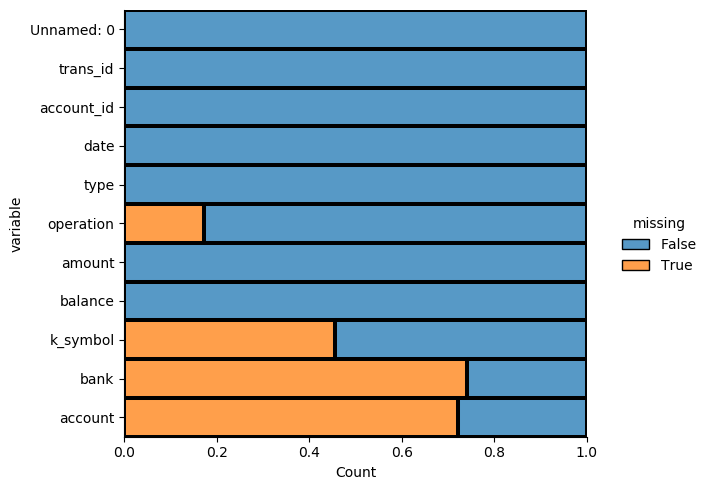

In [65]:
#Heat map for missing values
plt.figure(figsize=(6,6))
sns.displot(
    data=trans_1_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)
plt.show()

A heat map visualization of the missing values was produced. From this visualization it is evident that the following rows will need to handled for missing values: operation, k_symbol, bank, account.

In [66]:
# Variable type unique value
trans_1_df.type.unique()

array(['PRIJEM', 'VYDAJ', 'VYBER'], dtype=object)

In [67]:
# Variable trans_1_df.operation.unique() unique value
trans_1_df.operation.unique()

array(['VKLAD', 'PREVOD Z UCTU', 'PREVOD NA UCET', 'VYBER',
       'VYBER KARTOU', nan], dtype=object)

In [68]:
# Variable k_symbol unique value
trans_1_df.k_symbol.unique()

array([nan, 'SIPO', 'SLUZBY', 'UVER', ' ', 'POJISTNE', 'DUCHOD', 'UROK',
       'SANKC. UROK'], dtype=object)

In [69]:
# Variable bank unique value
trans_1_df.bank.unique()

array([nan, 'AB', 'YZ', 'ST', 'QR', 'WX', 'CD', 'UV', 'KL', 'GH', 'OP',
       'IJ', 'EF', 'MN'], dtype=object)

## Duplicate

In [70]:
#Duplicate rows
trans_1_df.duplicated().sum()

0

## Description

In [71]:
# Data description
trans_1_df.describe()

,Unnamed: 0,trans_id,account_id,amount,balance,account
count,1.056320e+06,1.056320e+06,1.056320e+06,1.056320e+06,1.056320e+06,2.953890e+05
mean,5.281595e+05,1.335311e+06,2.936867e+03,5.924211e+03,3.851838e+04,4.567092e+07
std,3.049335e+05,1.227487e+06,2.477345e+03,9.522698e+03,2.211787e+04,3.066340e+07
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-4.112600e+04,0.000000e+00
25%,2.640798e+05,4.302628e+05,1.204000e+03,1.360000e+02,2.240300e+04,1.782858e+07
50%,5.281595e+05,8.585065e+05,2.434000e+03,2.100000e+03,3.314300e+04,4.575095e+07
75%,7.922392e+05,2.060979e+06,3.660000e+03,6.800000e+03,4.960400e+04,7.201341e+07
max,1.056319e+06,3.682987e+06,1.138200e+04,8.740000e+04,2.096370e+05,9.999420e+07


The .describe() function was used to generate a statistical summary for the numerical columns present within the data. Statistical measurements such as percentiles, mean, and standard deviation were included.

## Correlation

In [72]:
#Correlation
trans_1_df.corr()

,Unnamed: 0,trans_id,account_id,amount,balance,account
Unnamed: 0,1.000000,0.912279,0.608843,-0.111753,0.038083,-0.069360
trans_id,0.912279,1.000000,0.506394,-0.169893,0.021019,-0.083874
account_id,0.608843,0.506394,1.000000,0.099779,0.128151,-0.083907
amount,-0.111753,-0.169893,0.099779,1.000000,0.457055,0.024737
balance,0.038083,0.021019,0.128151,0.457055,1.000000,-0.037802
account,-0.069360,-0.083874,-0.083907,0.024737,-0.037802,1.000000


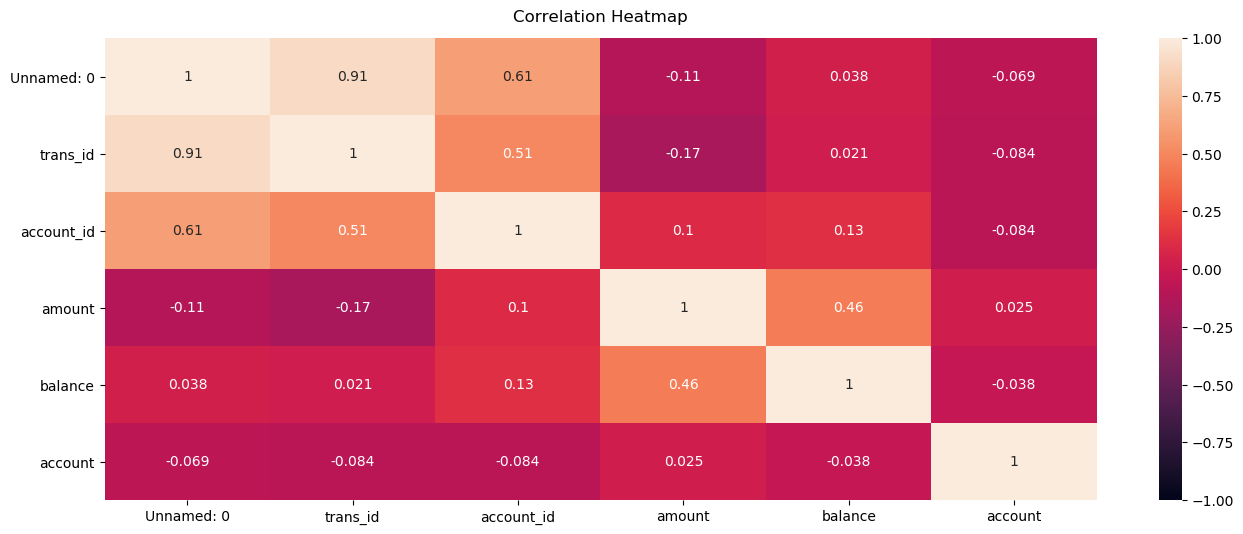

In [73]:
# Correlation Heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(trans_1_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

A correlation heatmap was produced in order to determine if there were any multicollinearity concerns. Looking at the correlation heat map it is evident that there are no concerns of multicollinearity that will need to be addressed while pre-processing the data as all of the correlation values are less than 0.7.

## Histogram of Numerical Variables 

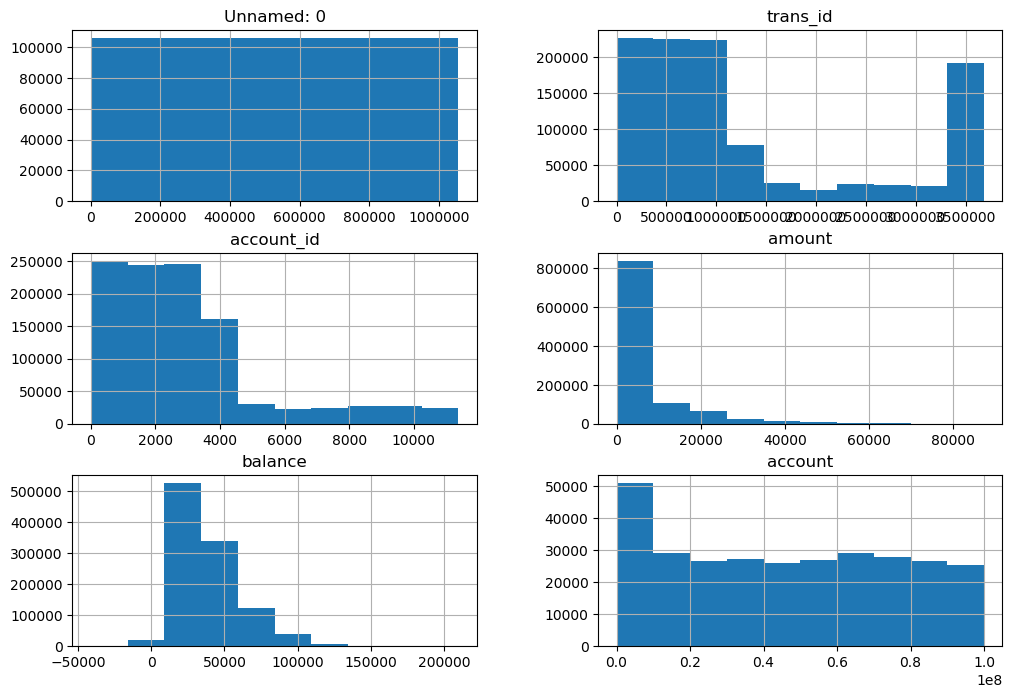

In [74]:
trans_1_df.hist(figsize=[12, 8])
plt.show()

 Looking at the histograms above it is evident the variables account_id, amount, balance, and account are right skewed. This indicates that the mean values are greater than the median values resulting in the data being positively skewed. The unnamed column is normally distributed and the trans_id column has a u-shaped distribution. Each of these distributions indicate that during the pre-processing normalization of the data through scaling and centering of the data should be considered.

## Bar Plot for Categorical Variables

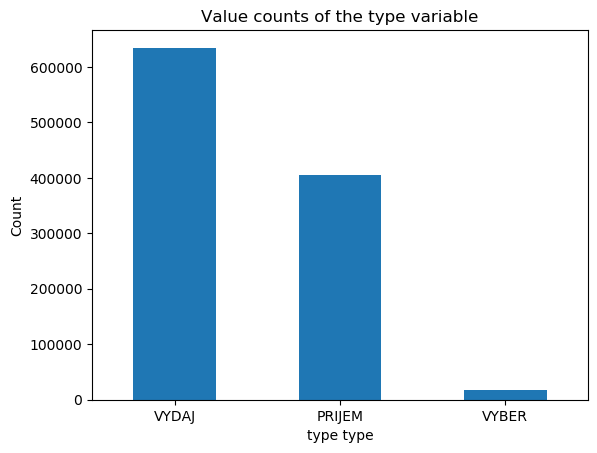

In [75]:
# Bar plot for type variable
trans_1_df.type.value_counts().plot(kind="bar")
plt.title("Value counts of the type variable")
plt.xlabel("type type")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

Looking at the histogram above it is evident that the data for the type variable is right skewed. This indicates that the mean values are greater than the median values resulting in the data being positively skewed.

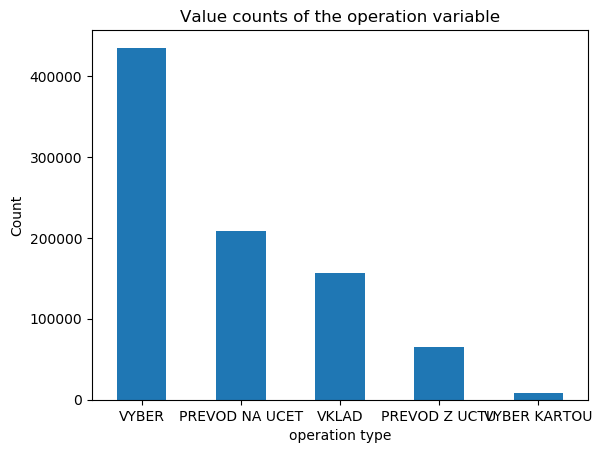

In [76]:
# Bar plot for operation variable
trans_1_df.operation.value_counts().plot(kind="bar")
plt.title("Value counts of the operation variable")
plt.xlabel("operation type")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

Looking at the histogram above it is evident that the data for the operation variable is right skewed. This indicates that the mean values are greater than the median values resulting in the data being positively skewed.

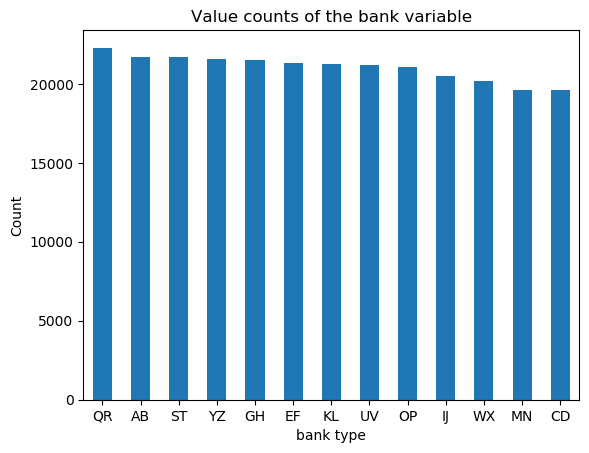

In [77]:
# Bar plot for bank variable
trans_1_df.bank.value_counts().plot(kind="bar")
plt.title("Value counts of the bank variable")
plt.xlabel("bank type")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

Looking at the histogram above it is evident that the data for the type variable is fairly uniformly distributed.

# Data # 2 trans_2

In [78]:
trans_2_df = wr.s3.read_csv(path="s3://s3://ads508patient/patient_folder/trans_2.csv")

In [79]:
trans_2_df.head()

,Unnamed: 0,transaction_id,type,operation,amount2,balance
0,0,289,Credit,Collection,0,0
1,1,290,Credit,Collection,0,0
2,2,291,Credit,Collection,0,0
3,3,292,Credit,Collection,0,0
4,4,293,Credit,Collection,0,0


In [80]:
trans_2_df.shape

(137326, 6)

The .shape() function was used in order to determine the number of rows and columns within this dataset. There are a total of 137,326 records and 6 columns.

## Visualizing Missing Values

<Figure size 600x600 with 0 Axes>

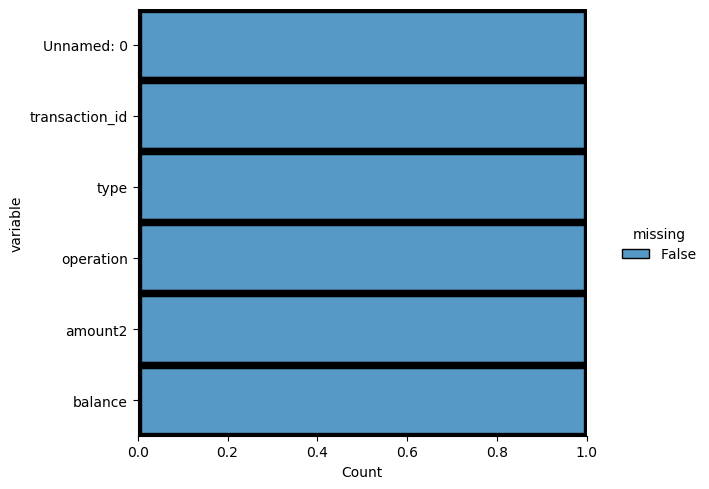

In [81]:
#Heat map for missing values
plt.figure(figsize=(6,6))
sns.displot(
    data=trans_2_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)
plt.show()

A heat map visualization of the missing values was produced. From this visualization it is evident that there are no missing values that need to be addressed while preprocessing the data.

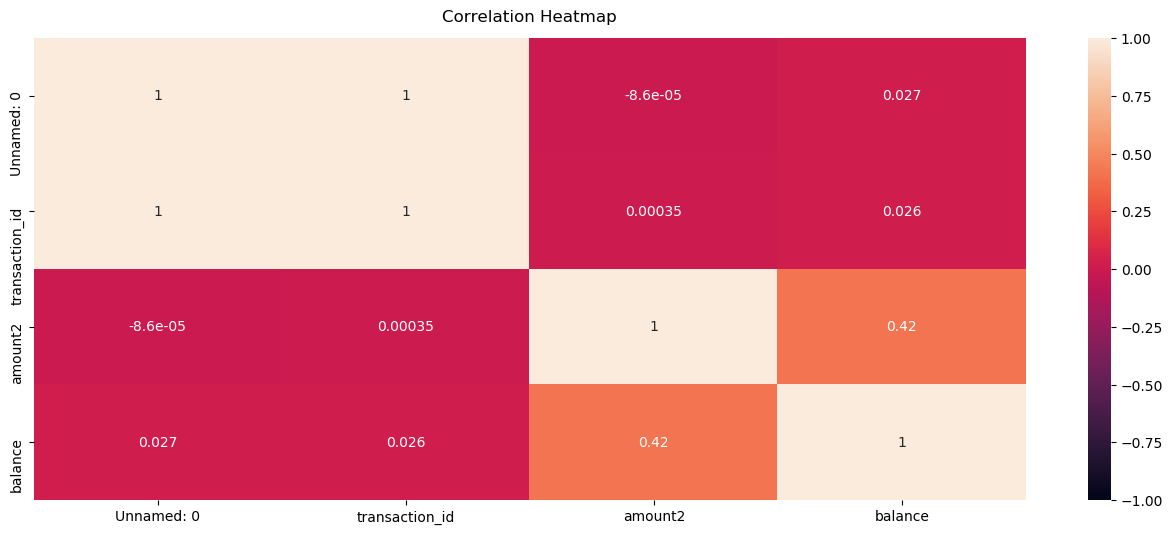

In [82]:
# Correlation Heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(trans_2_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

A correlation heatmap was produced in order to determine if there were any multicollinearity concerns. Looking at the correlation heat map it is evident that there are no concerns of multicollinearity that will need to be addressed while pre-processing the data as all of the correlation values are less than 0.7.

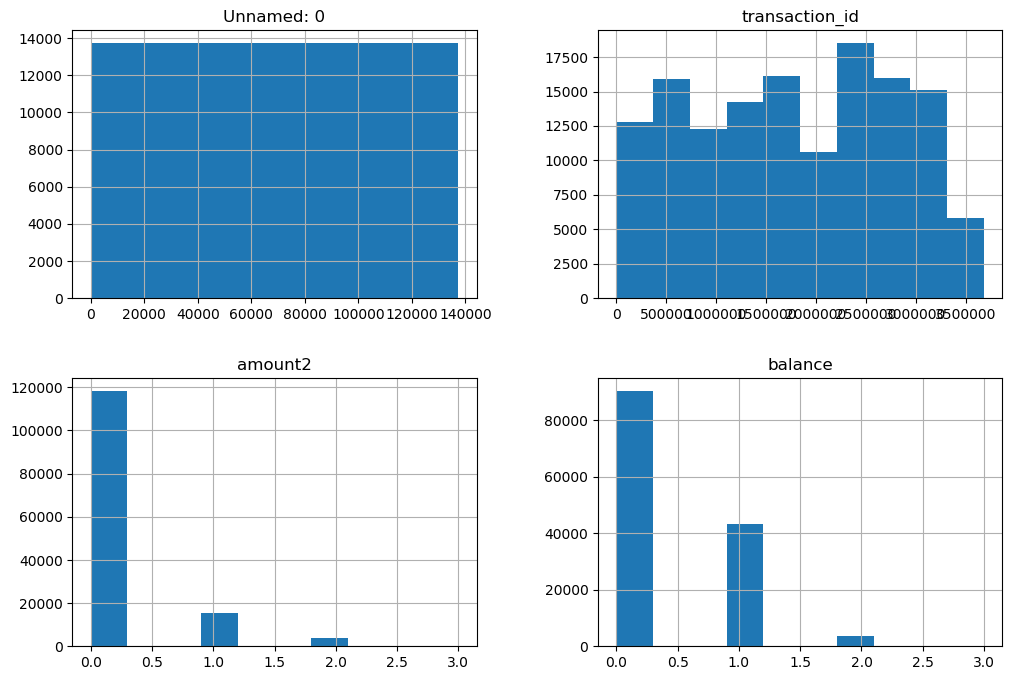

In [83]:
#Histogram for numerical values
trans_2_df.hist(figsize=[12, 8])
plt.show()

Looking at the histograms above it is evident the variables amount2 and balance are right skewed. This indicates that the mean values are greater than the median values resulting in the data being positively skewed. The unnamed column is normally distributed and the trans_id column has a u-shaped distribution. Each of these distributions indicate that during the pre-processing, normalization of the data through scaling and centering of the data should be considered.

## Bar Plot for Categorical Variables

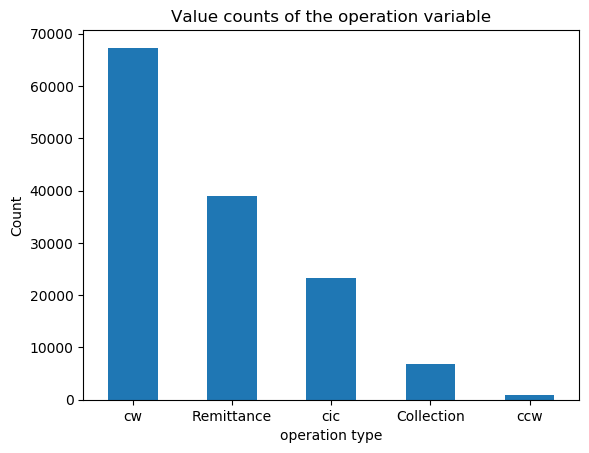

In [84]:
# Bar plot for operation variable
trans_2_df.operation.value_counts().plot(kind="bar")
plt.title("Value counts of the operation variable")
plt.xlabel("operation type")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()


Looking at the histogram above it is evident that the data for the operation variable is right skewed. This indicates that the mean values are greater than the median values resulting in the data being positively skewed.

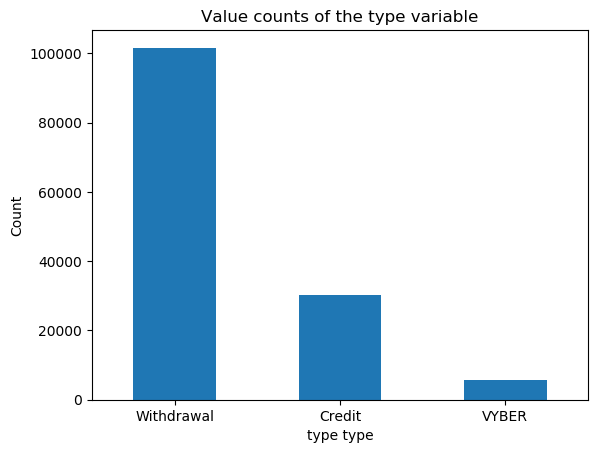

In [85]:
# Bar plot for type variable
trans_2_df.type.value_counts().plot(kind="bar")
plt.title("Value counts of the type variable")
plt.xlabel("type type")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

Looking at the histogram above it is evident that the data for the type variable is right skewed. This indicates that the mean values are greater than the median values resulting in the data being positively skewed. 

# Data # 3 client.csv

In [86]:
client_df = wr.s3.read_csv(path="s3://s3://ads508patient/patient_folder/client.csv")

In [87]:
client_df.head()

,Unnamed: 0,client_id,gender,birth_date,district_id
0,0,1,F,1970-12-13,18
1,1,2,M,1945-02-04,1
2,2,3,F,1940-10-09,1
3,3,4,M,1956-12-01,5
4,4,5,F,1960-07-03,5


In [88]:
client_df.shape

(5369, 5)

The .shape() function was used in order to determine the number of rows and columns within this dataset. There are a total of 5369 records and 5 columns.

<Figure size 600x600 with 0 Axes>

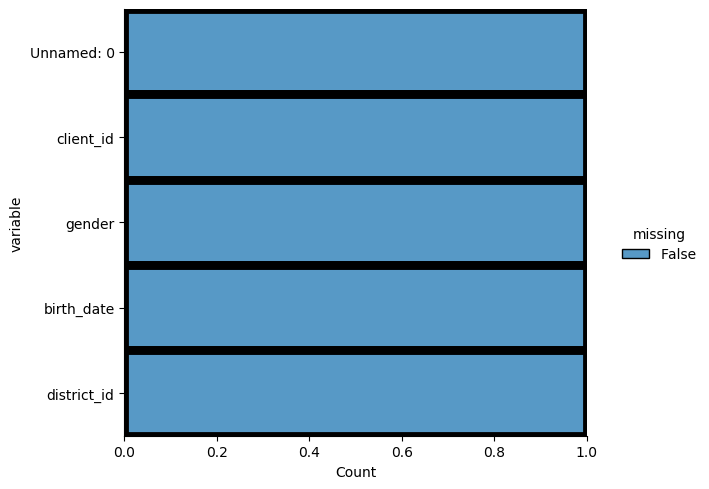

In [89]:
# Heat map for missing values
plt.figure(figsize=(6,6))
sns.displot(
    data=client_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)
plt.show()

A heat map visualization of the missing values was produced. From this visualization it is evident that there are no missing values that need to be addressed while preprocessing the data.

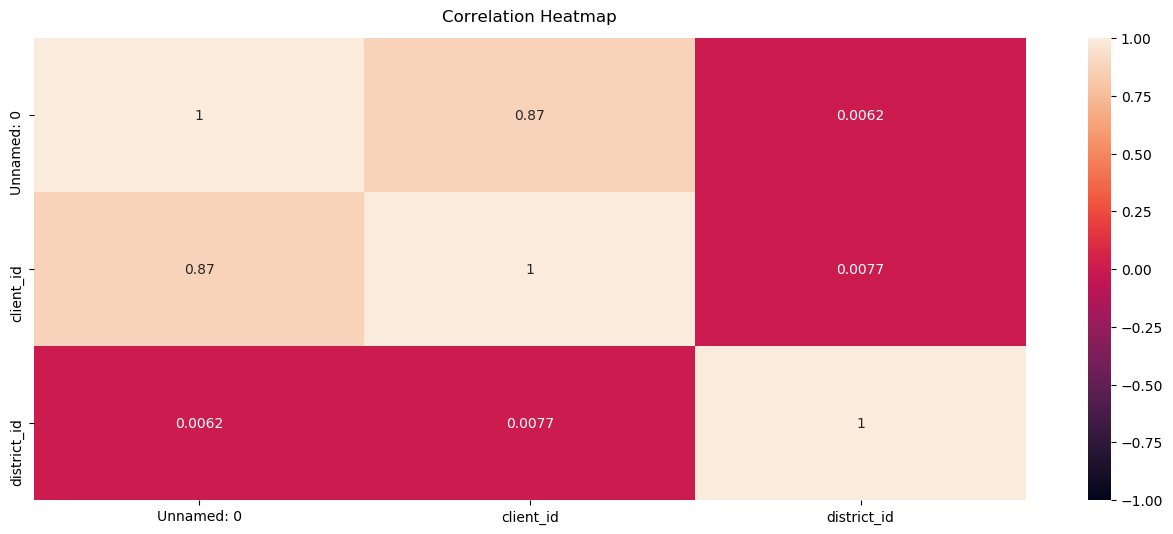

In [90]:
# Correlation Heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(client_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

A correlation heatmap was produced in order to determine if there were any multicollinearity concerns. Looking at the correlation heat map it is evident that there are no concerns of multicollinearity that will need to be addressed while pre-processing the data as all of the correlation values are less than 0.7.

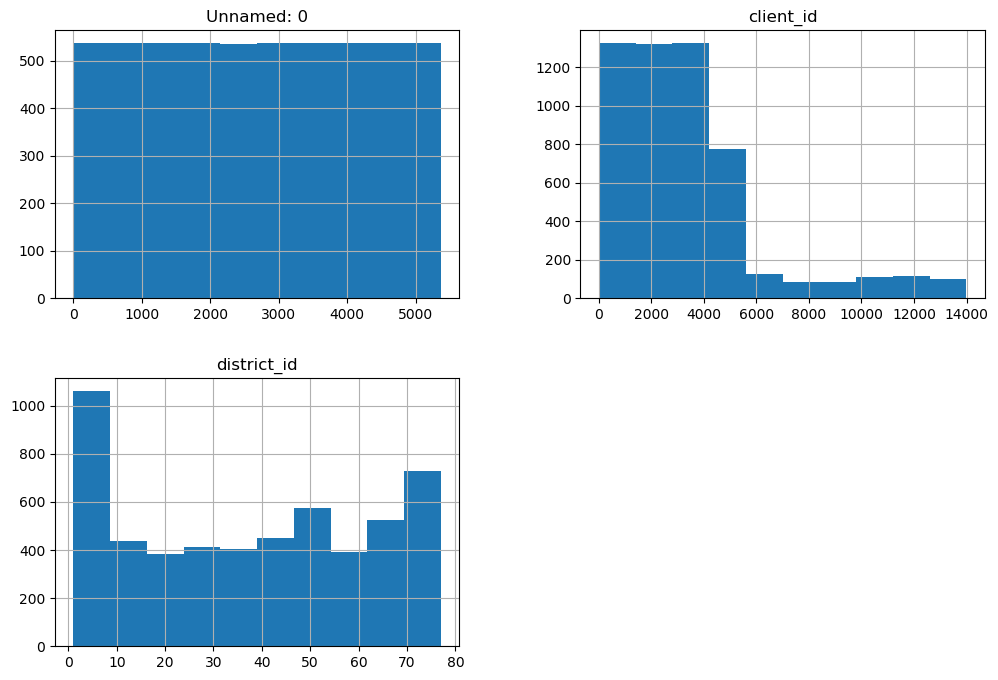

In [91]:
# Histogram for numerical values
client_df.hist(figsize=[12, 8])
plt.show()

Looking at the histograms above it is evident the variable client_id is right skewed. This indicates that the mean values are greater than the median values resulting in the data being positively skewed. The unnamed column is normally distributed and the district_id column has a u-shaped distribution. Each of these distributions indicate that during the pre-processing, normalization of the data through scaling and centering of the data should be considered.

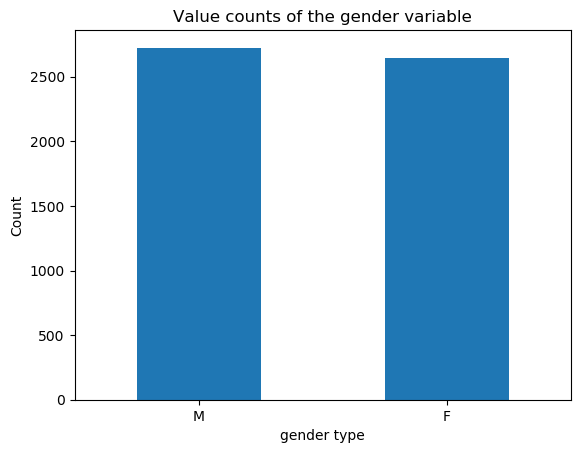

In [92]:
# Bar plot for gender variable
client_df.gender.value_counts().plot(kind="bar")
plt.title("Value counts of the gender variable")
plt.xlabel("gender type")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

Looking at the histogram above it is evident that the data for the gender variable is uniformly distributed. This indicates that there is mostly likely little to no bias in regards to gender when analyzing the data as there is equal amount of data per gender.

# Data # 4 loan.csv

In [93]:
Loan_df = wr.s3.read_csv(path="s3://s3://ads508patient/patient_folder/loan.csv")

In [94]:
Loan_df.head()

,Unnamed: 0,loan_id,account_id,date,amount,duration,payments,status
0,0,4959,2,1994-01-05,80952,24,3373.0,A
1,1,4961,19,1996-04-29,30276,12,2523.0,B
2,2,4962,25,1997-12-08,30276,12,2523.0,A
3,3,4967,37,1998-10-14,318480,60,5308.0,D
4,4,4968,38,1998-04-19,110736,48,2307.0,C


In [95]:
Loan_df.shape

(682, 8)

The .shape() function was used in order to determine the number of rows and columns within this dataset. There are a total of 682 records and 8 columns.

<Figure size 600x600 with 0 Axes>

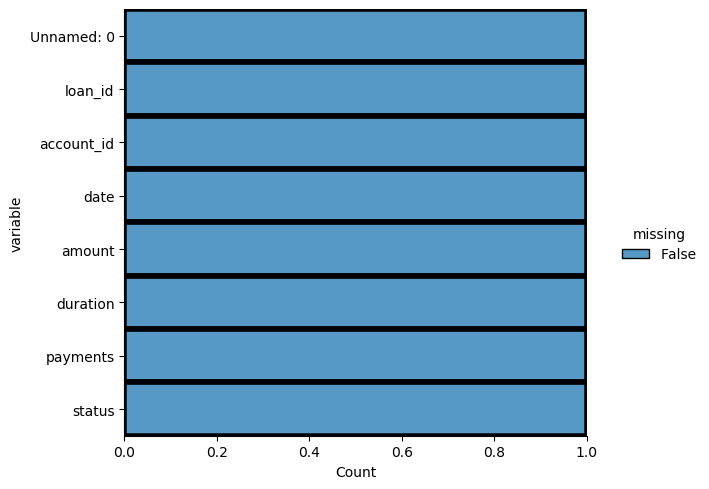

In [96]:
# Heat map for missing values
plt.figure(figsize=(6,6))
sns.displot(
    data=Loan_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)
plt.show()

A heat map visualization of the missing values was produced. From this visualization it is evident that there are no missing values that need to be addressed while preprocessing the data.

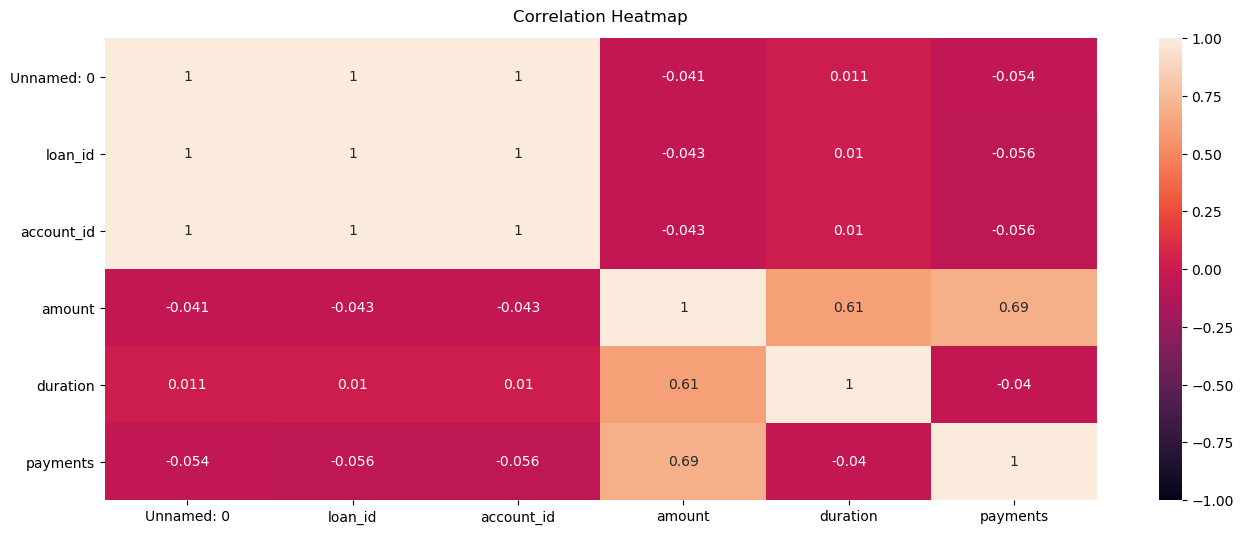

In [97]:
# Correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(Loan_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

A correlation heatmap was produced in order to determine if there were any multicollinearity concerns. Looking at the correlation heat map it is evident that there are no concerns of multicollinearity that will need to be addressed while pre-processing the data as all of the correlation values are less than 0.7.

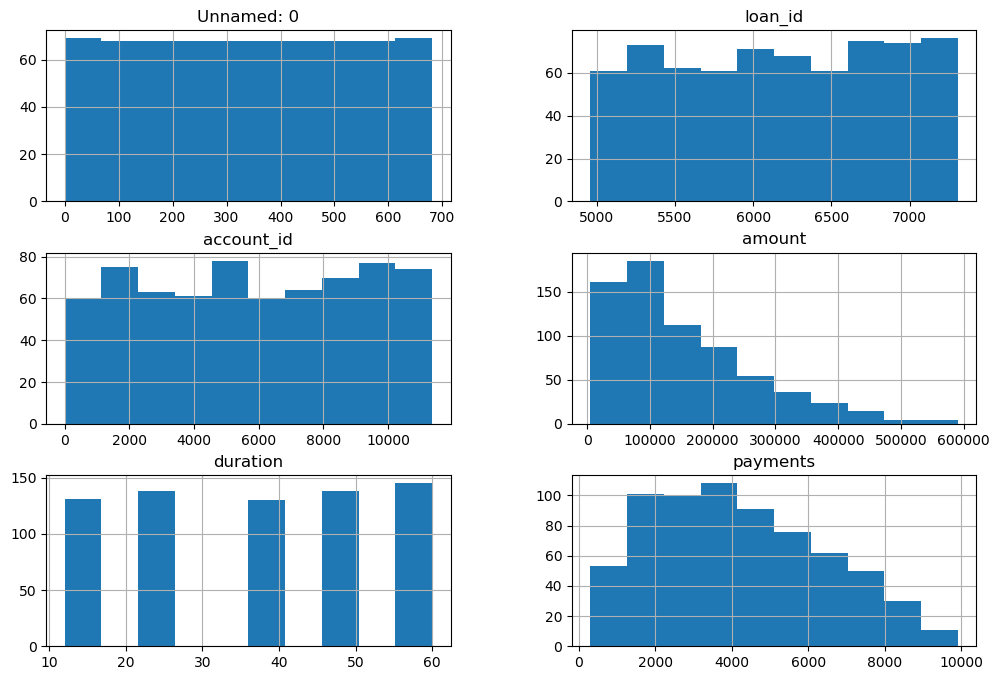

In [98]:
#Histogram for numerical values
Loan_df.hist(figsize=[12, 8])
plt.show()

Looking at the histograms above it is evident the variable amounts and payments are right skewed. This indicates that the mean values are greater than the median values resulting in the data being positively skewed. The unnamed column, duration, account_id, and loan_id is normally distributed. Each of these distributions indicate that during the pre-processing, normalization of the data through scaling and centering of the data should be considered.

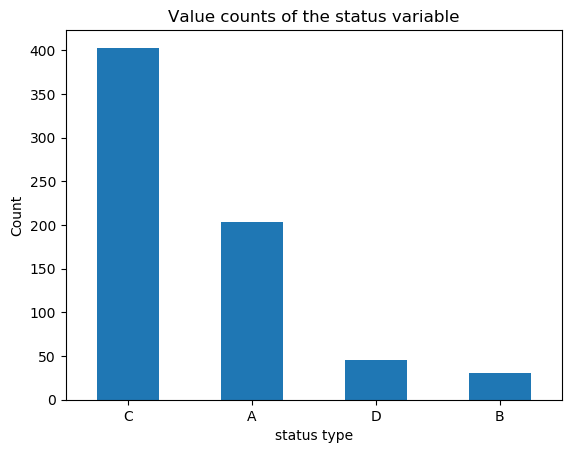

In [99]:
# Bar plot for status variable
Loan_df.status.value_counts().plot(kind="bar")
plt.title("Value counts of the status variable")
plt.xlabel("status type")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

The loan_status variable is our target variable. The status types C and A indicate a successful loan borrowing interaction and D and B indicate an unsuccessful loan borrowing interaction. Looking at the bar plot above it is evident that there is a class imbalance between the successful and unsuccessful loan borrowers. Based on this class imbalance, the data should most likely be split using a stratified approach along with the use of k-fold cross validation.

# Data # 5 accounts.csv

In [100]:
account_df = wr.s3.read_csv(path="s3://s3://ads508patient/patient_folder/account.csv")

In [101]:
account_df.head()

,Unnamed: 0,account_id,district_id,frequency,date
0,0,1,18,POPLATEK MESICNE,1995-03-24
1,1,2,1,POPLATEK MESICNE,1993-02-26
2,2,3,5,POPLATEK MESICNE,1997-07-07
3,3,4,12,POPLATEK MESICNE,1996-02-21
4,4,5,15,POPLATEK MESICNE,1997-05-30


In [102]:
account_df.shape

(4500, 5)

The .shape() function was used in order to determine the number of rows and columns within this dataset. There are a total of 4500 records and 5 columns.

<Figure size 600x600 with 0 Axes>

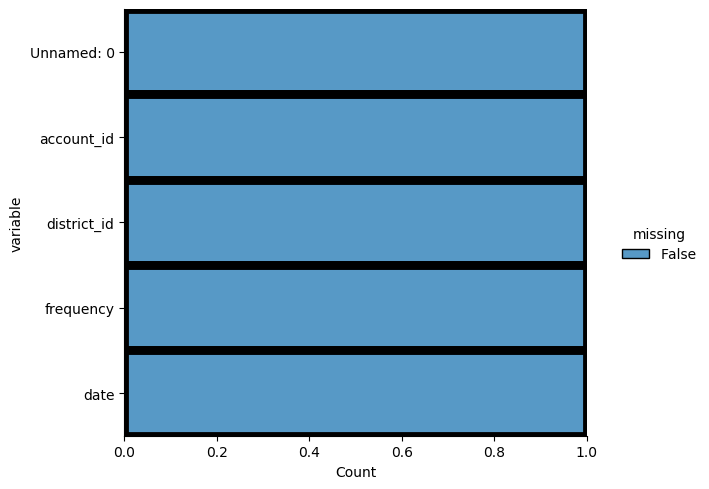

In [103]:
# Heat map for missing values
plt.figure(figsize=(6,6))
sns.displot(
    data=account_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)
plt.show()

A heat map visualization of the missing values was produced. From this visualization it is evident that there are no missing values that need to be addressed while preprocessing the data.

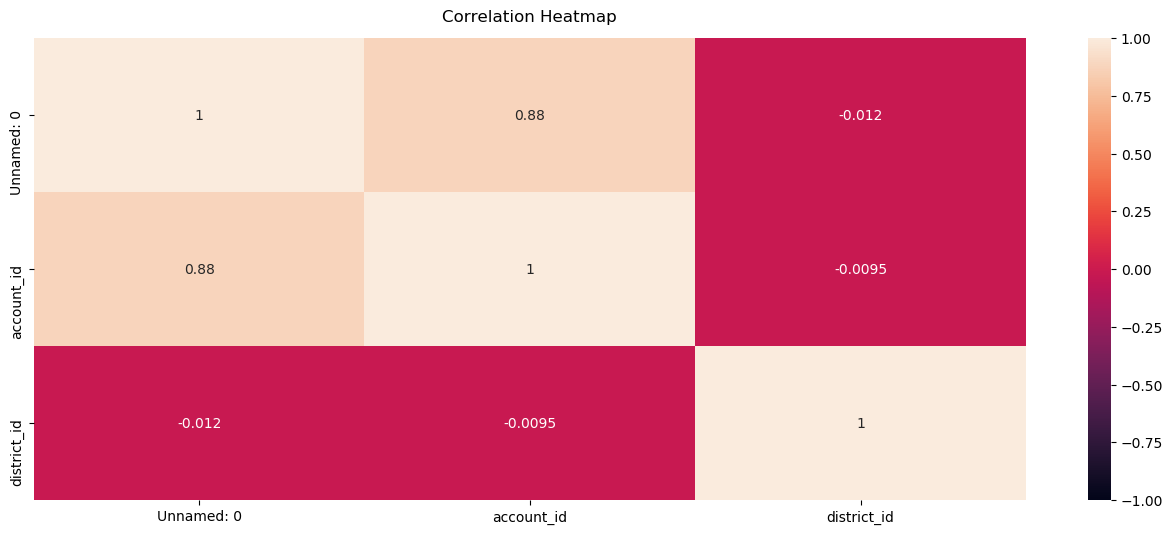

In [104]:
# Correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(account_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

A correlation heatmap was produced in order to determine if there were any multicollinearity concerns. Looking at the correlation heat map it is evident that there are no concerns of multicollinearity that will need to be addressed while pre-processing the data as all of the correlation values are less than 0.7

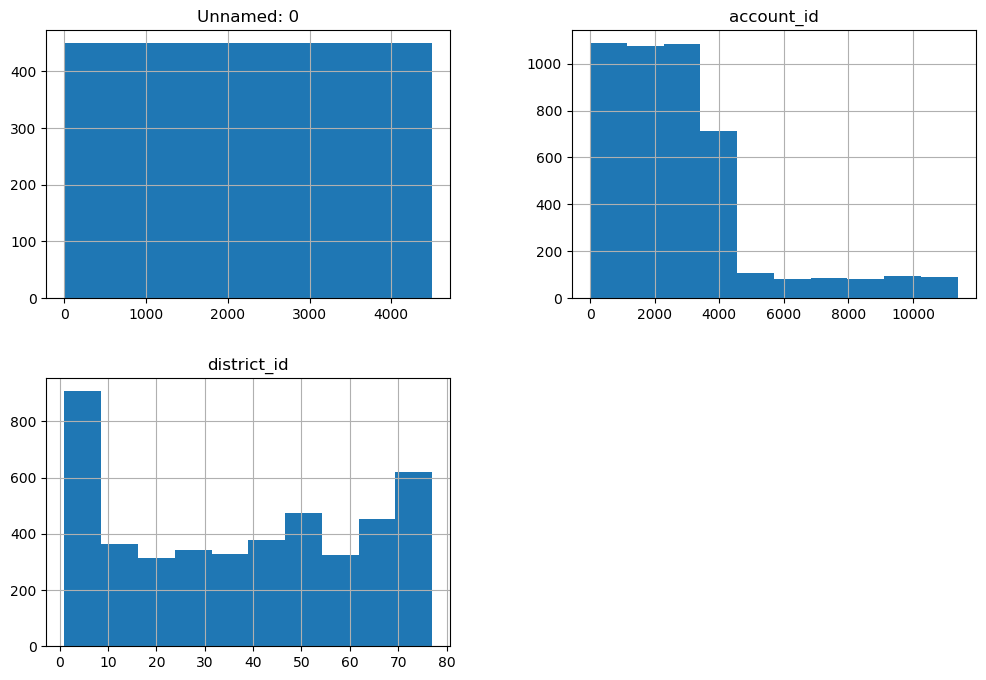

In [105]:
#Histogram for numerical values
account_df.hist(figsize=[12, 8])
plt.show()

Looking at the histograms above it is evident the variable account_id is right skewed.
This indicates that the mean values are greater than the median values resulting in the data being positively skewed. The unnamed column, and district_id are normally distributed. Each of these distributions indicate that during the pre-processing, normalization of the data through scaling and centering of the data should be considered.

## Data Preparation